In [145]:
import pandas as pd
import numpy as np
import re
import string
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import keras

In [146]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    BATCH_SIZE = 512  # Number of examples used in each iteration
    EPOCHS = 5  # Number of passes through entire dataset
    #MAX_LEN = 75  # Max length of review (in words)
    EMBEDDING = 40  # Dimension of word embedding vector
# Hyperparams for CPU training
else:
    BATCH_SIZE = 32
    EPOCHS = 5
    #MAX_LEN = 75
    EMBEDDING = 20

In [147]:
df = pd.read_excel (r'hindi_modelDataset.xlsx', sheet_name='Sheet1')
df.head(5)

,sent_index,word,tag
0,0,जापान,B-LOC
1,0,एशिया,B-LOC
2,0,महाद्वीप,I-LOC
3,0,में,O
4,0,स्थित,O


In [148]:
data = df.copy()

In [149]:
words = list(set(data["word"].values))
#words.append("ENDPAD")
n_words = len(words); 
n_words

17286

In [150]:
tags = list(set(data["tag"].values))
n_tags = len(tags); n_tags

7

In [151]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 0
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(),s["tag"].values.tolist())]
        self.grouped = self.data.groupby("sent_index").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
#         try:
        s = self.grouped[int("{}".format(self.n_sent))]
        self.n_sent += 1
        return s
#         except:
#             return None

In [152]:
#data[data['sent_index']==1]

In [153]:
getter = SentenceGetter(data)

In [154]:
print(getter.get_next())

[('जापान', 'B-LOC'), ('एशिया', 'B-LOC'), ('महाद्वीप', 'I-LOC'), ('में', 'O'), ('स्थित', 'O'), ('देश', 'O'), ('है', 'O'), ('।', 'O')]


In [155]:
sentences = getter.sentences

In [158]:
MAX_LEN  = max([len(s) for s in sentences])
print ('Maximum sequence length:', MAX_LEN)

Maximum sequence length: 348


In [159]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [160]:
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=MAX_LEN , sequences=X, padding="post", value=n_words-1)
X

array([[11555,  3814,  5651, ..., 17285, 17285, 17285],
       [ 8312, 13318,  4238, ..., 17285, 17285, 17285],
       [14385,  5204,  2060, ..., 17285, 17285, 17285],
       ...,
       [ 9278,   186, 10762, ..., 17285, 17285, 17285],
       [  321, 10054, 13698, ..., 17285, 17285, 17285],
       [13189,  8495, 11985, ..., 17285, 17285, 17285]])

In [161]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=MAX_LEN , sequences=y, padding="post", value=tag2idx["O"])


In [162]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)

# Setup the CRF-LSTM

In [163]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
import keras as k

In [164]:

# Model definition
input = Input(shape=(MAX_LEN,))
model = Embedding(input_dim=n_words+2, output_dim=EMBEDDING, # n_words + 2 (PAD & UNK)
                  input_length=MAX_LEN, mask_zero=True)(input)  # default: 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags)  # CRF layer, n_tags+1(PAD)
out = crf(model)  # output
model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])
model.summary()

C:\Users\sagun\anaconda3\envs\Capstone1\lib\site-packages\keras_contrib-2.0.8-py3.7.egg\keras_contrib\layers\crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
C:\Users\sagun\anaconda3\envs\Capstone1\lib\site-packages\keras_contrib-2.0.8-py3.7.egg\keras_contrib\layers\crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 348)               0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 348, 20)           345760    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 348, 100)          28400     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 348, 50)           5050      
_________________________________________________________________
crf_4 (CRF)                  (None, 348, 7)            420       
Total params: 379,630
Trainable params: 379,630
Non-trainable params: 0
_________________________________________________________________


In [169]:
history = model.fit(X_tr, np.array(y_tr), batch_size=BATCH_SIZE,epochs=EPOCHS,validation_split=0.1, verbose=2)

Train on 8845 samples, validate on 983 samples
Epoch 1/5
 - 129s - loss: 0.0904 - crf_viterbi_accuracy: 0.9673 - val_loss: 0.0298 - val_crf_viterbi_accuracy: 0.9894
Epoch 2/5
 - 138s - loss: 0.0217 - crf_viterbi_accuracy: 0.9924 - val_loss: 0.0171 - val_crf_viterbi_accuracy: 0.9940
Epoch 3/5
 - 136s - loss: 0.0115 - crf_viterbi_accuracy: 0.9961 - val_loss: 0.0125 - val_crf_viterbi_accuracy: 0.9959
Epoch 4/5
 - 136s - loss: 0.0060 - crf_viterbi_accuracy: 0.9982 - val_loss: 0.0118 - val_crf_viterbi_accuracy: 0.9963
Epoch 5/5
 - 135s - loss: 0.0030 - crf_viterbi_accuracy: 0.9992 - val_loss: 0.0086 - val_crf_viterbi_accuracy: 0.9979


In [170]:
model.save('bi_lstm_crf_hindi.h5')

In [172]:
i = 3
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
print("{:14} ({:5}): {}".format("Word", "True", "Pred"))
for w,pred in zip(X_te[i],p[0]):
    print("{:14}: {}".format(words[w],tags[pred]))

Word           (True ): Pred
गांधारी       : O
पूर्णिया      : I-PER
एड्स          : I-ORG
मॉन्ट्रियल    : I-ORG
यदु           : O
ग्रुब्स       : O
फ़्रांका      : I-ORG
डेयर          : I-ORG
आंकिक         : O
सुशीला        : I-ORG
खूबसूरत       : O
अग्रदूत       : O
ग्रुब्स       : O
कथाओं         : I-LOC
बंधन          : B-LOC
जिज़ान        : I-ORG
निश्चल        : I-PER
लगाते         : O
विश्वविद्यालयों: I-ORG
सेनेटर        : O
९२            : O
खूबसूरत       : O
गांधीवादी     : O
कैसर          : O
कैसर          : O
कैसर          : O
कैसर          : O
कैसर          : O
कैसर          : O
कैसर          : O
कैसर          : O
कैसर          : O
कैसर          : O
कैसर          : O
कैसर          : O
कैसर          : O
कैसर          : O
कैसर          : O
कैसर          : O
कैसर          : O
कैसर          : O
कैसर          : O
कैसर          : O
कैसर          : O
कैसर          : O
कैसर          : O
कैसर          : O
कैसर          : O
कैसर          : O
कैसर          : O
कैसर          : O
कैसर    

In [173]:

from tqdm import tqdm


In [174]:
pred = []
for i in tqdm(range(len(y_te))):
    p = model.predict(np.array([X_te[i]]))
    p = np.argmax(p, axis=-1)
    pred.append(p)

100%|██████████| 1093/1093 [01:20<00:00, 13.58it/s]


In [175]:
pred_temp = [x[0] for x in pred]

y_temp = []

for i in range(len(y_te)):
    y_temp.append(np.array([np.where(y_te[i][j]==1)[0][0] for j in range(len(y_te[i]))]))

In [176]:
actual = y_temp[0]
for i in range(1, len(y_temp)):
    actual = np.concatenate((actual, y_temp[i]), axis=None)

In [177]:
predicted = pred_temp[0]
for i in range(1, len(pred_temp)):
    predicted = np.concatenate((predicted, pred_temp[i]), axis=None)

In [178]:
import scikitplot as skplt
from sklearn.metrics import classification_report

              precision    recall  f1-score   support

       B-LOC       0.97      0.95      0.96       933
       I-ORG       0.96      0.96      0.96      2217
       B-PER       0.66      0.81      0.72       467
       I-PER       0.97      0.94      0.95      1609
       I-LOC       0.94      0.95      0.95       716
           O       1.00      1.00      1.00    373754
       B-ORG       0.65      0.94      0.77       668

    accuracy                           1.00    380364
   macro avg       0.88      0.94      0.90    380364
weighted avg       1.00      1.00      1.00    380364



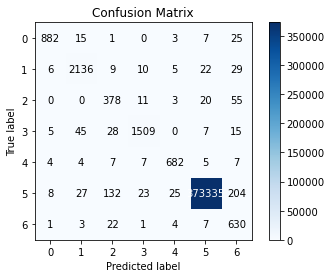

In [179]:
skplt.metrics.plot_confusion_matrix(actual, predicted)
print(classification_report(actual, predicted, target_names=tags))